In [56]:
import tensorflow as tf
tf.executing_eagerly()
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.utils import normalize
from tensorflow.keras.metrics import MeanIoU



In [201]:
import torch

In [39]:
# Resizing images, if needed
SIZE_X = 64
SIZE_Y = 64
n_classes = 5  # Number of classes for segmentation


In [22]:
# Capture training image info as a list
train_images = []
for directory_path in glob.glob("/Users/ganievanvar/RoadAR/4points_segmentation/cars64x64/Input/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, 1)
        # img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
# Convert list to array for machine learning processing
train_images = np.array(train_images)

In [23]:
# Capture mask/label info as a list
train_masks = []
for directory_path in glob.glob("/Users/ganievanvar/RoadAR/4points_segmentation/cars64x64/Target/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        # mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
# Convert list to array for machine learning processing
train_masks = np.array(train_masks)

In [24]:
# Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1, 1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

/Users/ganievanvar/opt/anaconda3/envs/road_signs/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [25]:
np.unique(train_masks_encoded_original_shape)

array([0, 1, 2, 3, 4])

In [26]:
# увеличиваем размерность на 1  
# train_images = np.expand_dims(train_images, axis=3)
# train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [27]:
print('train_images.shape = {}'.format(train_images.shape), 
      '\ntrain_masks_input.shape = {}'.format(train_masks_input.shape))

train_images.shape = (52310, 64, 64, 3) 
train_masks_input.shape = (52310, 64, 64, 1)


In [28]:
# Create a subset of data for quick testing
# Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split

X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size=0.10, random_state=0)

# Further split training data to a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size=0.2, random_state=0)

print("Class values in the dataset are  ", np.unique(y_train))  # 0 is the background/few unlabeled

Class values in the dataset are   [0 1 2 3 4]


In [29]:
# так как классов больше 2, то нужно использовать categorical (one-hot-encoding)
from tensorflow.keras.utils import to_categorical 

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))



In [30]:
# последнее число должно совпадать с кол-вом классов с учетом бэкграунда
print('y_test_cat shape = {} '.format(y_test_cat.shape))

y_test_cat shape = (5231, 64, 64, 5) 


# Задаем общие параметры

In [52]:
activation='softmax'

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)


dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25/140, 0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [54]:


BACKBONE3 = 'mobilenetv2'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)


# preprocess input
X_train3 = preprocess_input3(X_train)
X_test3 = preprocess_input3(X_test)


# define model
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model3.compile(optim, total_loss, metrics)
#model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model3.summary())






/Users/ganievanvar/opt/anaconda3/envs/road_signs/lib/python3.8/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 1s 0us/step
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
____________________________

In [55]:
history3=model3.fit(X_train3, 
          y_train_cat,
          batch_size=32, 
          epochs=10,
          verbose=1,
          validation_data=(X_test3, y_test_cat))

Epoch 1/10
 267/1177 [=====>........................] - ETA: 12:22 - loss: 1.0179 - iou_score: 0.0868 - f1-score: 0.1226

KeyboardInterrupt: 

In [ ]:
model3.save('mobilenetv2_backbone_10epochs.hdf5')


# Графики потерь и точности

In [ ]:

#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [63]:
model_path = '/Users/ganievanvar/RoadAR/4points_segmentation/models/mobilenetv2_backbone_50epochs.hdf5'
model_mobnet = tf.keras.models.load_model(model_path, compile=False)


In [67]:
pred_mobnet = model_mobnet.predict(X_test2)

In [68]:
pred_mobnet.shape

(5231, 64, 64, 5)

In [75]:
y_pred_mobnet_argmax= np.argmax(pred_mobnet, axis=3)

In [71]:
y_pred_mobnet.shape

(5231, 64, 64)

In [76]:
IOU_mobnet = MeanIoU(num_classes=n_classes)

In [77]:
# y_test[:,:,:,0] - значения настоящие
# y_pred_mobnet_argmax - предикты
IOU_mobnet.update_state(y_test[:,:,:,0], y_pred_mobnet_argmax)

<tf.Variable 'UnreadVariable' shape=(5, 5) dtype=float64, numpy=
array([[2.000065e+07, 2.202300e+05, 1.841910e+05, 2.474490e+05,
        1.669900e+05],
       [8.507900e+04, 5.528400e+04, 0.000000e+00, 1.133600e+04,
        0.000000e+00],
       [8.323400e+04, 0.000000e+00, 5.316600e+04, 1.920000e+02,
        1.510700e+04],
       [1.086330e+05, 1.925400e+04, 0.000000e+00, 2.368200e+04,
        0.000000e+00],
       [8.536600e+04, 0.000000e+00, 1.641600e+04, 1.710000e+02,
        4.974600e+04]])>

In [79]:
print('IOU Score for model_mobnet = ', IOU_mobnet.result().numpy())

IOU Score for model_mobnet =  0.2886323


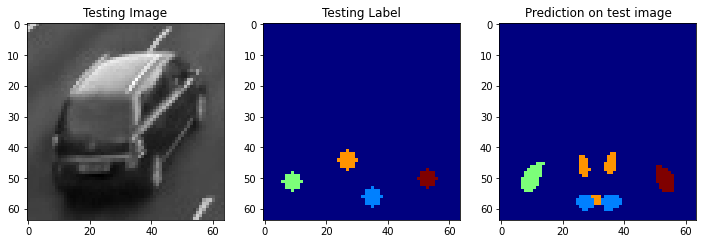

In [341]:
import random

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,:]
test_img_input=np.expand_dims(test_img_norm, 0)

#Weighted average ensemble


test_img_input_mobnet = preprocess_input2(test_img_input)

test_pred_mobnet = model_mobnet.predict(test_img_input_mobnet)
test_prediction = np.argmax(test_pred_mobnet, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction, cmap='jet')
plt.show()

# Нахождение координат с помощью сегментации

In [298]:
def find_centers(pred_tensor):
    img_centers = []
    for i in range(pred_tensor.shape[0]):
        temp_centers = []
        for point_class in range(1, 5):
            
            x_max = np.where(pred_tensor[i] == point_class)[0].max()
            x_min = np.where(pred_tensor[i] == point_class)[0].min()

            y_max = np.where(pred_tensor[i] == point_class)[1].max()
            y_min = np.where(pred_tensor[i] == point_class)[1].min()

            center = ((x_max - (x_max - x_min) / 2) / 64, (y_max - (y_max - y_min) / 2) / 64)

            temp_centers.append(center)
            
        img_centers.append(temp_centers)
        
    return img_centers

In [319]:
test_images = []
for directory_path in glob.glob("/Users/ganievanvar/RoadAR/4points_segmentation/cars64x64/Test/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path)
        # img = cv2.resize(img, (SIZE_Y, SIZE_X))
        test_images.append(img)
# Convert list to array for machine learning processing
test_images = np.array(test_images)

# preprocess input for mobilenetv2
X_test = preprocess_input2(test_images)

/Users/ganievanvar/RoadAR/4points_segmentation/cars64x64/Test/0.780112_0.594418_0.324446_0.916146_0.382012_0.752191_0.722546_0.758373_.jpg
/Users/ganievanvar/RoadAR/4points_segmentation/cars64x64/Test/0.607676_0.910608_0.358498_0.654215_0.775370_0.788900_0.190804_0.775922_.jpg
/Users/ganievanvar/RoadAR/4points_segmentation/cars64x64/Test/0.701820_0.494296_0.335369_0.866868_0.284239_0.676158_0.752949_0.685005_.jpg
/Users/ganievanvar/RoadAR/4points_segmentation/cars64x64/Test/0.700785_0.491340_0.335946_0.879071_0.287085_0.681081_0.749645_0.689330_.jpg
/Users/ganievanvar/RoadAR/4points_segmentation/cars64x64/Test/0.702162_0.504439_0.341884_0.902970_0.286018_0.699237_0.758028_0.708172_.jpg
/Users/ganievanvar/RoadAR/4points_segmentation/cars64x64/Test/0.315908_0.887725_0.726422_0.457102_0.732958_0.668872_0.309372_0.675955_.jpg
/Users/ganievanvar/RoadAR/4points_segmentation/cars64x64/Test/0.417442_0.593244_0.549014_0.915629_0.135446_0.761049_0.831010_0.747823_.jpg
/Users/ganievanvar/RoadAR/4

In [309]:
pred_mobnet = model_mobnet.predict(X_test)
y_pred_mobnet_argmax= np.argmax(pred_mobnet, axis=3)

In [310]:
coodinates_Unet = find_centers(y_pred_mobnet_argmax)

In [322]:
coodinates_Unet 

[[(0.90625, 0.5),
  (0.78125, 0.1484375),
  (0.796875, 0.5),
  (0.7734375, 0.828125)],
 [(0.8984375, 0.4921875),
  (0.7734375, 0.15625),
  (0.7734375, 0.4921875),
  (0.7734375, 0.828125)],
 [(0.90625, 0.4921875),
  (0.7734375, 0.15625),
  (0.7890625, 0.4921875),
  (0.7734375, 0.828125)],
 [(0.90625, 0.4921875),
  (0.7734375, 0.1640625),
  (0.78125, 0.5),
  (0.78125, 0.8359375)],
 [(0.90625, 0.4921875),
  (0.7734375, 0.1640625),
  (0.7890625, 0.5),
  (0.7734375, 0.828125)],
 [(0.8984375, 0.4921875),
  (0.7734375, 0.1640625),
  (0.703125, 0.4921875),
  (0.78125, 0.8359375)],
 [(0.8984375, 0.5),
  (0.7734375, 0.15625),
  (0.7734375, 0.484375),
  (0.7734375, 0.828125)],
 [(0.8984375, 0.4921875),
  (0.78125, 0.15625),
  (0.7734375, 0.484375),
  (0.7734375, 0.8203125)],
 [(0.90625, 0.4921875),
  (0.7734375, 0.1640625),
  (0.796875, 0.4921875),
  (0.7734375, 0.828125)],
 [(0.8984375, 0.5078125),
  (0.7734375, 0.15625),
  (0.7890625, 0.53125),
  (0.7734375, 0.828125)],
 [(0.90625, 0.5),
  (0.7

4096